In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import torchvision.models as models
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import numpy as np
import copy
from pathlib import Path
import json
import time
%matplotlib inline

In [10]:
SEED = 42
BATCH_SIZE = 128
NUM_EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [4]:
class CIFAR10CNN(nn.Module):
    def __init__(self, activation='relu', init_type='xavier'):
        super(CIFAR10CNN, self).__init__()

        # Define activation function
        self.activation = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'leaky_relu': nn.LeakyReLU(0.1)
        }[activation]

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc_bn = nn.BatchNorm1d(512)
        self.fc_dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

        # Initialize weights
        self.init_weights(init_type)

    def init_weights(self, init_type):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                if init_type == 'xavier':
                    nn.init.xavier_uniform_(m.weight)
                elif init_type == 'kaiming':
                    nn.init.kaiming_uniform_(m.weight)
                else:  # random
                    nn.init.uniform_(m.weight, -0.1, 0.1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Convolutional layers
        x = self.pool1(self.activation(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        x = self.pool2(self.activation(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        x = self.pool3(self.activation(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        # Flatten
        x = x.view(-1, 256 * 4 * 4)

        # Fully connected layers
        x = self.activation(self.fc_bn(self.fc1(x)))
        x = self.fc_dropout(x)
        x = self.fc2(x)

        return x

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform_train)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform_test)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 170M/170M [00:19<00:00, 8.67MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
def train_model(model, train_loader, val_loader, optimizer_name='adam', lr=0.001):
    """Train and evaluate model with specified optimizer"""
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()

    # Initialize optimizer
    if optimizer_name == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:  # rmsprop
        optimizer = optim.RMSprop(model.parameters(), lr=lr)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0

    for epoch in range(NUM_EPOCHS):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        # Calculate metrics
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * correct / total
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total

        # Update scheduler
        scheduler.step(val_loss)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'epoch': epoch
            }, f'best_model_{optimizer_name}.pth')

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print("-" * 50)

    return history, best_val_acc

In [7]:
def plot_results(histories, title):
    """Plot training and validation metrics"""
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    for name, history in histories.items():
        plt.plot(history['train_loss'], label=f'{name}_train')
        plt.plot(history['val_loss'], label=f'{name}_val')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    for name, history in histories.items():
        plt.plot(history['train_acc'], label=f'{name}_train')
        plt.plot(history['val_acc'], label=f'{name}_val')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.close()

In [23]:
def fine_tune_model(model_name, train_loader, val_loader, lr=0.0001):
    """Fine-tune different pre-trained models"""
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
    elif model_name == 'resnet101':
        model = models.resnet101(pretrained=True)
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
    else:
        raise ValueError("Unsupported model")

    # Freeze feature extractor layers
    for param in model.parameters():
        param.requires_grad = False

    # Modify the final classification layer
    if 'resnet' in model_name:
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif 'vgg' in model_name:
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 10)
    elif 'efficientnet' in model_name:
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)

    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    best_acc = 0
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = 100. * correct / total
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")

    return model

In [ ]:
activations = ['relu', 'tanh', 'leaky_relu']
initializations = ['xavier', 'kaiming', 'random']
optimizers = ['sgd', 'adam', 'rmsprop']

results = {}
histories = {}

In [ ]:
# Run experiments with custom CNN
for act in activations:
    for init in initializations:
        for opt in optimizers:
            print(f"Initialization: {init}, Activation: {act}, Optimizer: {opt}")
            config_name = f"{init}_{act}_{opt}"
            model = CIFAR10CNN(activation=act, init_type=init)
            history, acc = train_model(model, train_loader, test_loader, opt)

            results[config_name] = acc
            histories[config_name] = history

Initialization: xavier, Activation: relu, Optimizer: sgd
Epoch 1/2
Train Loss: 2.2547, Train Acc: 24.52%
Val Loss: 1.6459, Val Acc: 39.38%
--------------------------------------------------
Epoch 2/2
Train Loss: 1.8994, Train Acc: 32.70%
Val Loss: 1.5203, Val Acc: 44.36%
--------------------------------------------------
Initialization: xavier, Activation: relu, Optimizer: adam
Epoch 1/2
Train Loss: 1.8239, Train Acc: 36.28%
Val Loss: 1.2309, Val Acc: 55.56%
--------------------------------------------------
Epoch 2/2
Train Loss: 1.4165, Train Acc: 48.91%
Val Loss: 1.0982, Val Acc: 60.75%
--------------------------------------------------
Initialization: xavier, Activation: relu, Optimizer: rmsprop
Epoch 1/2
Train Loss: 1.7632, Train Acc: 37.69%
Val Loss: 1.2679, Val Acc: 54.24%
--------------------------------------------------
Epoch 2/2
Train Loss: 1.3976, Train Acc: 49.55%
Val Loss: 1.0478, Val Acc: 63.05%
--------------------------------------------------
Initialization: kaiming, A

In [ ]:
# Save results
with open('experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

# Plot results
plot_results(histories, 'CIFAR-10 Model Comparison')

# Print best configuration
best_config = max(results.items(), key=lambda x: x[1])
print(f"\nBest configuration: {best_config[0]} with accuracy {best_config[1]:.2f}%")

C:\Users\anujj\AppData\Local\Temp\ipykernel_21448\4244679600.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()



Best configuration: xavier_relu_rmsprop with accuracy 63.05%


In [16]:
def plot_training_history(history):
    """Plots training & validation accuracy and loss."""
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.show()

Epoch 1/20
Train Loss: 1.7749, Train Acc: 37.67%
Val Loss: 1.3036, Val Acc: 52.55%
--------------------------------------------------
Epoch 2/20
Train Loss: 1.3825, Train Acc: 49.88%
Val Loss: 1.0512, Val Acc: 61.96%
--------------------------------------------------
Epoch 3/20
Train Loss: 1.2358, Train Acc: 55.70%
Val Loss: 0.9364, Val Acc: 67.11%
--------------------------------------------------
Epoch 4/20
Train Loss: 1.1411, Train Acc: 59.68%
Val Loss: 0.8708, Val Acc: 69.63%
--------------------------------------------------
Epoch 5/20
Train Loss: 1.0654, Train Acc: 62.29%
Val Loss: 0.8238, Val Acc: 71.18%
--------------------------------------------------
Epoch 6/20
Train Loss: 1.0172, Train Acc: 63.80%
Val Loss: 0.7664, Val Acc: 73.29%
--------------------------------------------------
Epoch 7/20
Train Loss: 0.9764, Train Acc: 65.56%
Val Loss: 0.7556, Val Acc: 73.70%
--------------------------------------------------
Epoch 8/20
Train Loss: 0.9416, Train Acc: 66.96%
Val Loss: 0.7

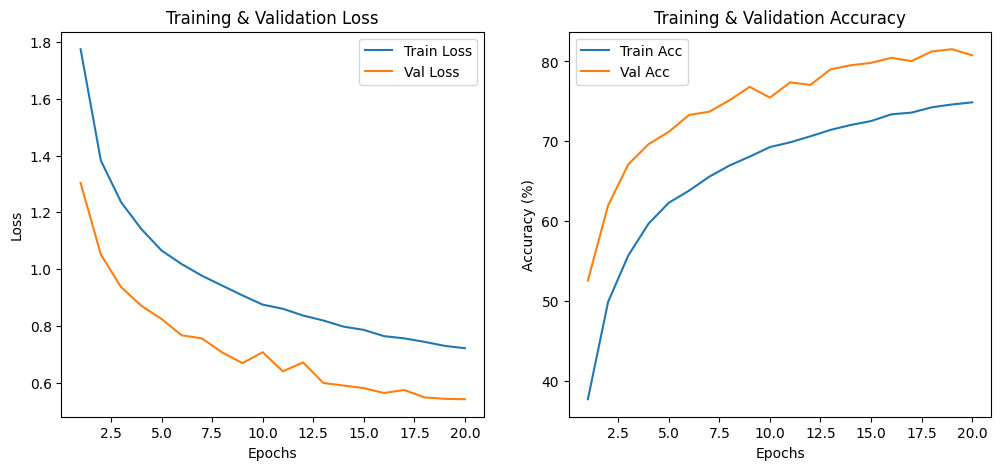

In [17]:
model = CIFAR10CNN(activation="relu", init_type="xavier")
history, acc = train_model(model, train_loader, test_loader, "rmsprop")

plot_training_history(history)

print("Final Accuracy: ", acc)

In [24]:
# models_to_test = ['resnet18', 'resnet50', 'resnet101', 'vgg16', 'efficientnet_b0']
models_to_test = ['resnet18']

results = {}
for model_name in models_to_test:
    print(f"Training {model_name}...")
    results[model_name] = fine_tune_model(model_name, train_loader, test_loader)

Training resnet18...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 - Loss: 868.6417, Acc: 20.05%
Epoch 2/20 - Loss: 758.6956, Acc: 31.34%
Epoch 3/20 - Loss: 721.1369, Acc: 35.59%
Epoch 4/20 - Loss: 700.9393, Acc: 37.32%
Epoch 5/20 - Loss: 689.9640, Acc: 38.24%
Epoch 6/20 - Loss: 680.8485, Acc: 39.29%
Epoch 7/20 - Loss: 674.0013, Acc: 39.81%
Epoch 8/20 - Loss: 669.1888, Acc: 40.38%
Epoch 9/20 - Loss: 667.6017, Acc: 40.34%
Epoch 10/20 - Loss: 662.5851, Acc: 40.74%
Epoch 11/20 - Loss: 661.6605, Acc: 41.06%
Epoch 12/20 - Loss: 659.3247, Acc: 41.35%
Epoch 13/20 - Loss: 659.0523, Acc: 41.15%
Epoch 14/20 - Loss: 657.5428, Acc: 41.56%
Epoch 15/20 - Loss: 653.9743, Acc: 41.50%
Epoch 16/20 - Loss: 656.2270, Acc: 41.38%
Epoch 17/20 - Loss: 652.2449, Acc: 41.96%
Epoch 18/20 - Loss: 648.8335, Acc: 42.14%
Epoch 19/20 - Loss: 648.0253, Acc: 42.16%
Epoch 20/20 - Loss: 648.6345, Acc: 42.17%
